## Green Line Extension Analysis

Since 2005, the MBTA had been planning the Green Line Extension project to extend the Green Line into Somerville and Medford. The project extends the Lechmere line, diverging to Union Square in Somerville, and Tufts University in Medford. The MBTA has estimated that the line will support 45,000 one-way trips by 2030. The extension also included an additional vehicle maintenance and storage yard located in Somerville. The line has been intermittently under construction since 2018, finally being completed in December 2022. This makes the stops and lines along the extension the most recent additions to be added to Boston's train infrastructure. This mid-semester report aims to explore demographic characteristics relating to displacement and their change over time during the construction of the extension.

Observing these trends requires data collected at a granular level, which is only available via the U.S. Census. The Census Bureau manages the American Community Survey, which contains community data and subsequent estimates down to a block level. The Census Bureau maintains the multi-year data to provide more statistically accurate insights on smaller communities and issues that might otherwise not have relevant or accurate data. The data is broken down on a tract level, so we used Boston's census tract breakdowns to identify the tracts that are largely covered by the extension project.

The extension project is largely focused in Middlesex county, and the maps below show a side-by-side comparison of the project and tracts.

## Green Line Extension Map and Tracts

In [611]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

tracts = 'green-line-census-tracts.png'
map = 'green-line-extension.png'

html = f"""
<table><tr>
<td><img src='{map}' width='600'></td>
<td><img src='{tracts}' width='520'></td>
</tr></table>
"""
display(HTML(html))

,


Link to Middlesex County Tracts: https://www2.census.gov/geo/maps/DC2020/PL20/st25_ma/censustract_maps/c25017_middlesex/DC20CT_C25017.pdf

The train line passes through several tracts in three different census-designated areas:
- Cambridge (green): 3521.01, 3521.02, 3522, 3527
- Somerville (purple): 3503, 3504, 3505, 3506, 3502.01, 3502.02, 3510.01, 3511.01, 3511.02, 3501.08, 3512.04, 3512.03, 3513, 3515, 3514.04, 3514.03, 3501.09, 3501.07
- Medford (orange): 3394, 3395, 3396, 3397

Below are relevant surveys for the tracts:
- [SO802](https://data.census.gov/table/ACSST5Y2022.S0802?g=1400000US25017339400,25017339500,25017339600,25017339700,25017350107,25017350108,25017350109,25017350201,25017350202,25017350300,25017350400,25017350500,25017350600,25017351001,25017351101,25017351102,25017351203,25017351204,25017351300,25017351403,25017351404,25017351500,25017352101,25017352102,25017352200,25017352700): Means of Transportation to Work
- [SO601](https://data.census.gov/table/ACSST5Y2022.S0601?g=1400000US25017339400,25017339500,25017339600,25017339700,25017350107,25017350108,25017350109,25017350201,25017350202,25017350300,25017350400,25017350500,25017350600,25017351001,25017351101,25017351102,25017351203,25017351204,25017351300,25017351403,25017351404,25017351500,25017352101,25017352102,25017352200,25017352700): General Characteristics of the Population
- [DP04](https://data.census.gov/table/ACSDP5Y2022.DP04?t=Homeownership%20Rate&g=1400000US25017339400,25017339500,25017339600,25017339700,25017350107,25017350108,25017350109,25017350201,25017350202,25017350300,25017350400,25017350500,25017350600,25017351001,25017351101,25017351102,25017351203,25017351204,25017351300,25017351403,25017351404,25017351500,25017352101,25017352102,25017352200,25017352700): Selected Housing Characteristics



## Cleaning Survey Data

Each survey is conducted on an annual basis. The code below combines the annual surveys into one CSV per survey, and trims unhelpful columns.

In [612]:
import pandas as pd

# Retrieves all surveys for a chosen survey
def retrieve_survey_data(survey):
    years = ['2018', '2019', '2020', '2021', '2022']
    surveys = []
    for year in years:
        file_path = f'../../data/green-line-extension-data/{survey}/{survey}-{year}.csv'
        data = pd.read_csv(file_path)
        surveys.append((data, year))
    return surveys

# Filter for S06901
def dp04_filter(data, year):
    # Filtering columns
    filtered_columns = [col for col in data.columns if not ("Margin of Error" in col) ]
    data = data[filtered_columns]
    data.columns = [col.split('County')[0] + f'County, {year}'if 'County' in col else col + f' {year}' for col in data.columns]

    # Filtering rows
    saved_categories = [
        "HOUSING OCCUPANCY", 
        "UNITS IN STRUCTURE", 
        "YEAR STRUCTURE BUILT",
        "HOUSING TENURE",
        "YEAR HOUSEHOLDER MOVED INTO UNIT",
        "VALUE",
        "MORTGAGE STATUS",
        "SMOC",
        "SMOCAPI",
        "GROSS RENT",
        "GRAPI"
    ]
    keep_rows = []
    relevant_section = False
    for index, row in data.iterrows():
        if pd.isna(row.iloc[1]):
            relevant_section = False
        if any(category in str(row.iloc[0]) for category in saved_categories):
            relevant_section = True
        if relevant_section:
            keep_rows.append(index)
    data = data.iloc[keep_rows]
    return data

# Filter for S06901
def s0601_filter(data, year):
    # Filtering columns
    filtered_columns = [col for col in data.columns if "Massachusetts!!Total!!Estimate" in col or "Label" in col]
    data = data[filtered_columns]
    data.columns = [col.split('County')[0] + f'County, {year}'if 'County' in col else col + f' {year}' for col in data.columns]

    # Filtering rows
    saved_categories = [
        "RACE AND HISPANIC OR LATINO ORIGIN", 
        "INDIVIDUALS' INCOME IN THE PAST 12 MONTHS", 
        "POVERTY STATUS"
    ]
    keep_rows = []
    relevant_section = False
    for index, row in data.iterrows():
        if pd.isna(row.iloc[1]):
            relevant_section = False
        if any(category in str(row.iloc[0]) for category in saved_categories):
            relevant_section = True
        if relevant_section:
            keep_rows.append(index)
    data = data.iloc[keep_rows]
    return data

# Filter for S06901
def s0802_filter(data, year):
    # Filtering columns
    filtered_columns = [col for col in data.columns if "Massachusetts!!Total!!Estimate" in col or "Label" in col]
    data = data[filtered_columns]
    data.columns = [col.split('County')[0] + f'County, {year}'if 'County' in col else col + f' {year}' for col in data.columns]

    # Filtering rows
    saved_categories = [
        "AGE", 
        "SEX", 
        "POVERTY STATUS",
        "PLACE OF WORK",
        "TIME LEAVING HOME TO GO TO WORK",
        "TRAVEL TIME TO WORK",
        "HOUSING TENURE",
        "VEHICLES AVAILABLE",
        "PERCENT ALLOCATED"
        
    ]
    keep_rows = []
    relevant_section = False
    for index, row in data.iterrows():
        if pd.isna(row.iloc[1]):
            relevant_section = False
        if any(category in str(row.iloc[0]) for category in saved_categories):
            relevant_section = True
        if relevant_section:
            keep_rows.append(index)
    data = data.iloc[keep_rows]
    return data

def combine_years(dfs):
    label_column = dfs[0].iloc[:, 0]
    trimmed_dfs = [df.iloc[:, 1:] for df in dfs]    
    combined_df = pd.concat(trimmed_dfs, axis=1)
    combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
    sorted_df = combined_df.sort_index(axis=1)    
    sorted_df.insert(0, 'Label', label_column)
    return sorted_df

def preprocess(df):
    df = df.transpose()
    df.columns = df.iloc[0]    
    df = df.drop(df.index[0])    
    df.reset_index(inplace=True)    
    df.rename(columns={df.columns[0]: 'Tract'}, inplace=True)
    split_data = df['Tract'].str.split(' ', expand=True)
    df['Year'] = split_data.iloc[:, -1]
    df['Tract'] = split_data.iloc[:, 2]
    df['Tract'] = df['Tract'].str[:-1]
    df.columns = df.columns.str.replace('\xa0', ' ', regex=True)
    
    return df

In [613]:
dp04 = retrieve_survey_data('dp04')
dp04 = [dp04_filter(data, year) for data, year in dp04]
dp04 = preprocess(combine_years(dp04))
dp04.to_csv('../../data/green-line-extension-data/dp04/dp04.csv', index=False)

In [614]:
s0601 = retrieve_survey_data('s0601')
s0601 = [s0601_filter(data, year) for data, year in s0601]
s0601 = preprocess(combine_years(s0601))
s0601.to_csv('../../data/green-line-extension-data/s0601/s0601.csv', index=False)

In [615]:
s0802 = retrieve_survey_data('s0802')
s0802 = [s0802_filter(data, year) for data, year in s0802]
s0802 = preprocess(combine_years(s0802))
s0802.to_csv('../../data/green-line-extension-data/s0802/s0802.csv', index=False)

## Housing Characteristics Analysis

In [616]:
dp04 = pd.read_csv('../../data/green-line-extension-data/dp04/dp04.csv')

### Calculating Percent Change in Median Rent, Mortgage, and Home Value by Tract

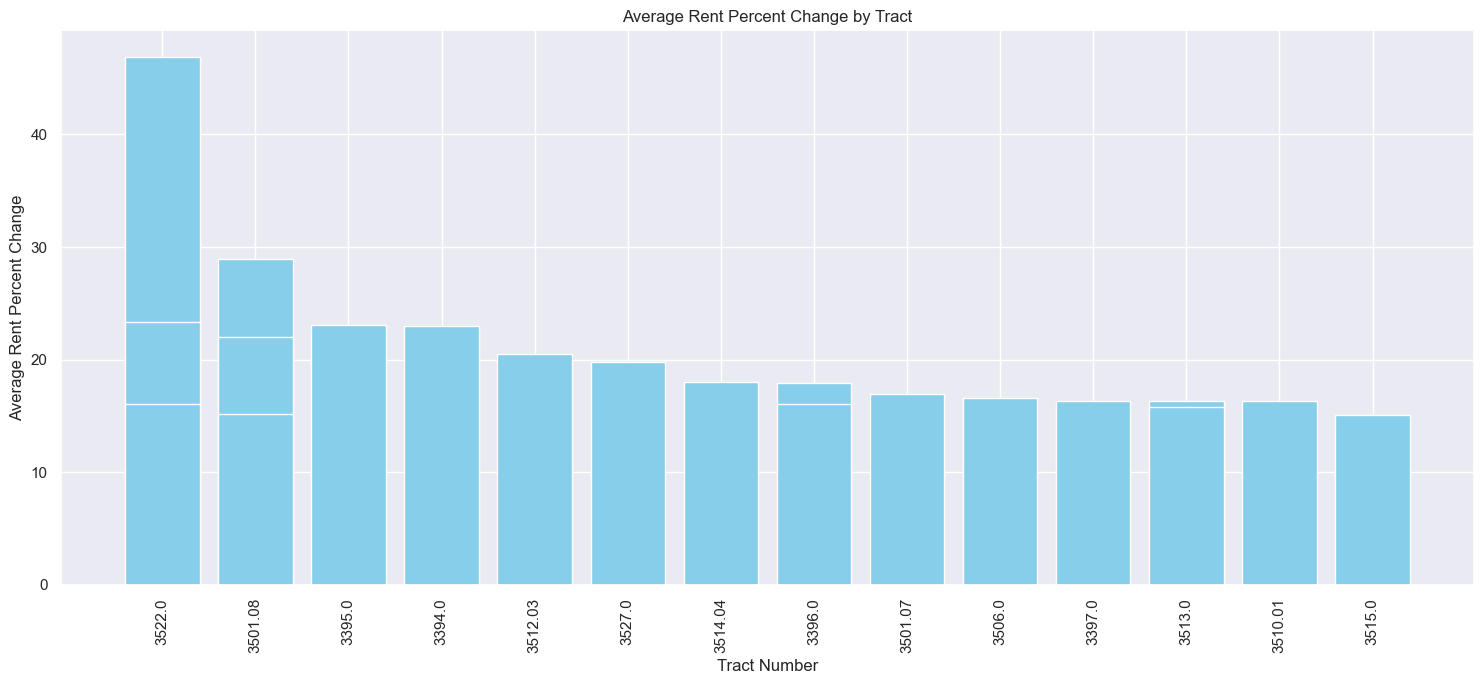

In [617]:
import matplotlib.pyplot as plt

median_columns = [col for col in dp04.columns if 'Median' in col]
rename_dict = {
    median_columns[0]: 'Value Median',
    median_columns[1]: 'SMOC Median',
    median_columns[2]: 'Mortgage Median',
    median_columns[3]: 'Rent Median'
}
dp04.rename(columns=rename_dict, inplace=True)

dp04.sort_values(by=['Tract', 'Year'], inplace=True)
dp04['Rent Median'] = dp04['Rent Median'].str.replace(',', '')
dp04['Rent Median'] = pd.to_numeric(dp04['Rent Median'], errors='coerce')
dp04['rent_percent_change'] = dp04.groupby('Tract')['Rent Median'].pct_change(fill_method=None)
dp04['avg_rent_percent_change'] = dp04.groupby('Tract')['rent_percent_change'].transform('mean')
dp04['rent_percent_change'].fillna(dp04['avg_rent_percent_change'], inplace=True)
dp04.drop('avg_rent_percent_change', axis=1, inplace=True)
dp04['rent_percent_change'] = dp04['rent_percent_change'] * 100

plot_data = dp04[['Tract', 'rent_percent_change']]
plot_data = plot_data.sort_values(by='rent_percent_change', ascending=False)
plot_data = plot_data.head(20)

plt.figure(figsize=(15, 7))
plt.bar(plot_data['Tract'].astype(str), plot_data['rent_percent_change'], color='skyblue')
plt.xlabel('Tract Number')
plt.ylabel('Average Rent Percent Change')
plt.title('Average Rent Percent Change by Tract')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

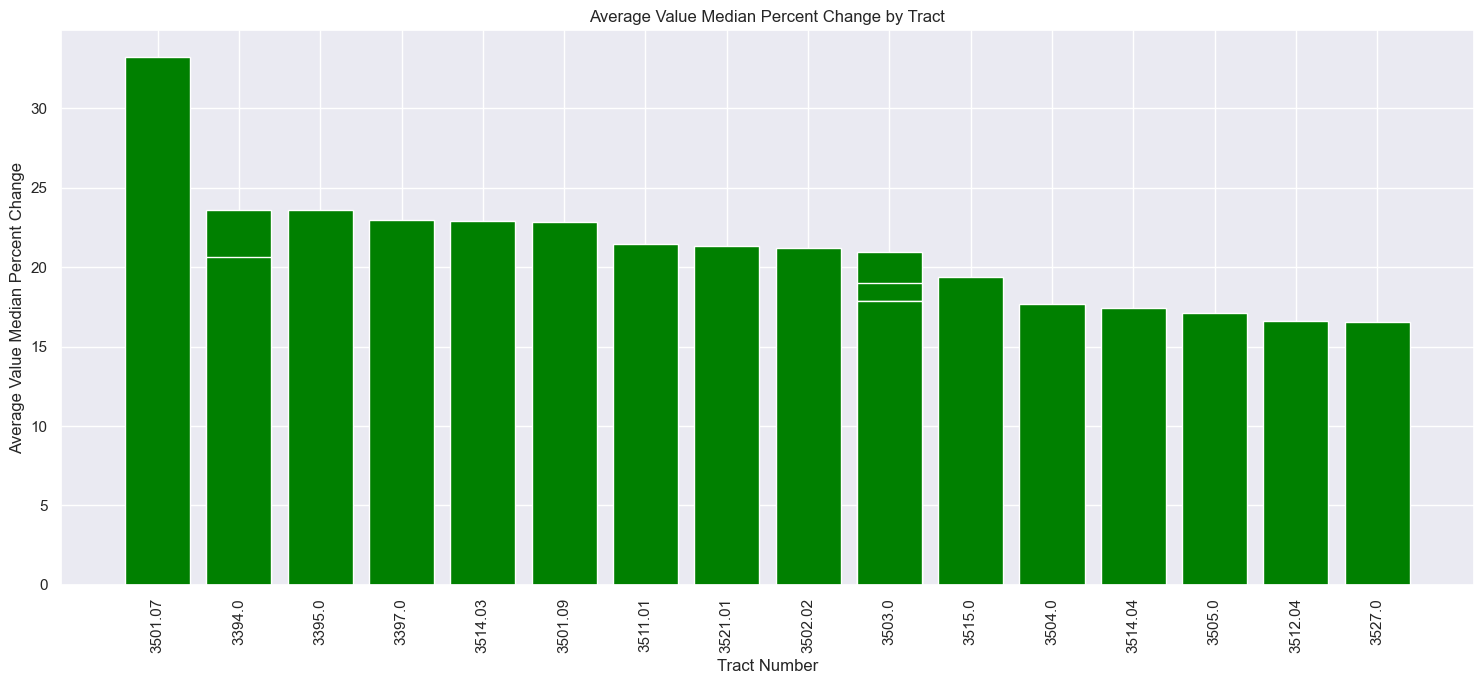

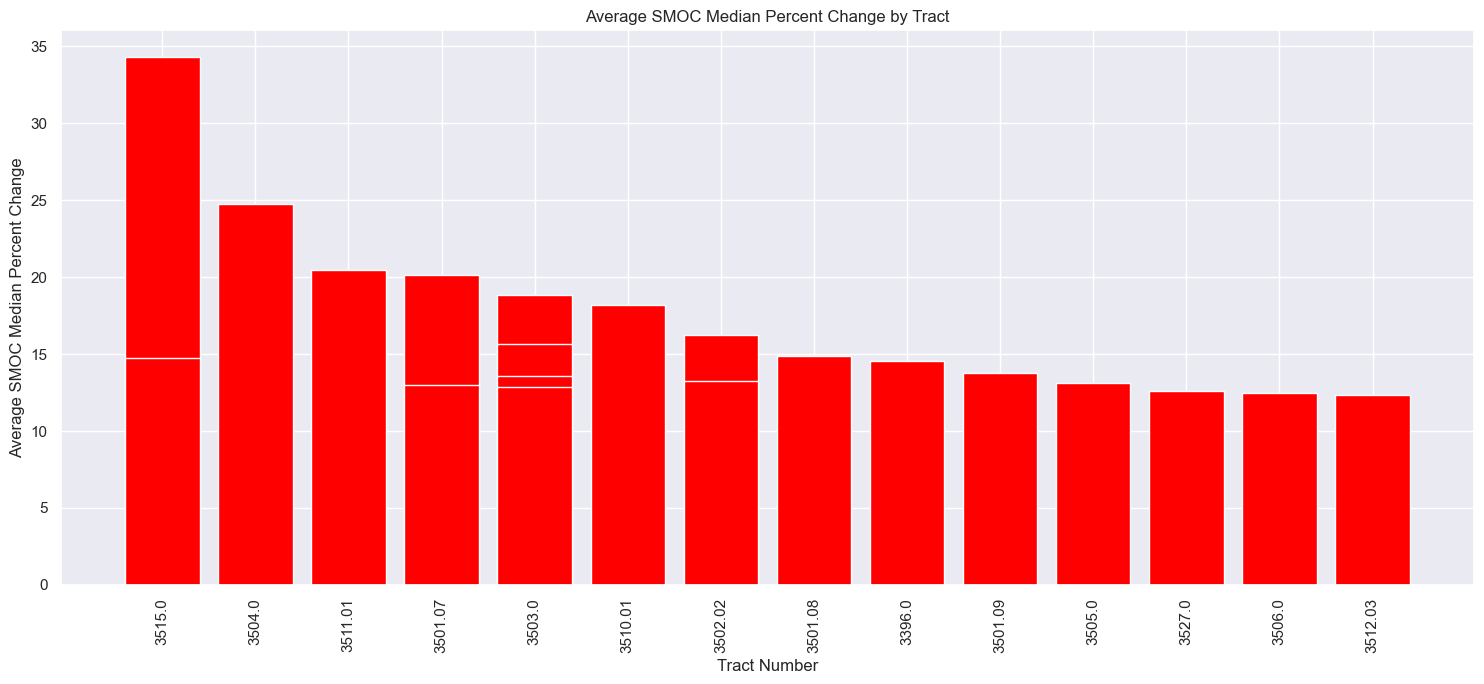

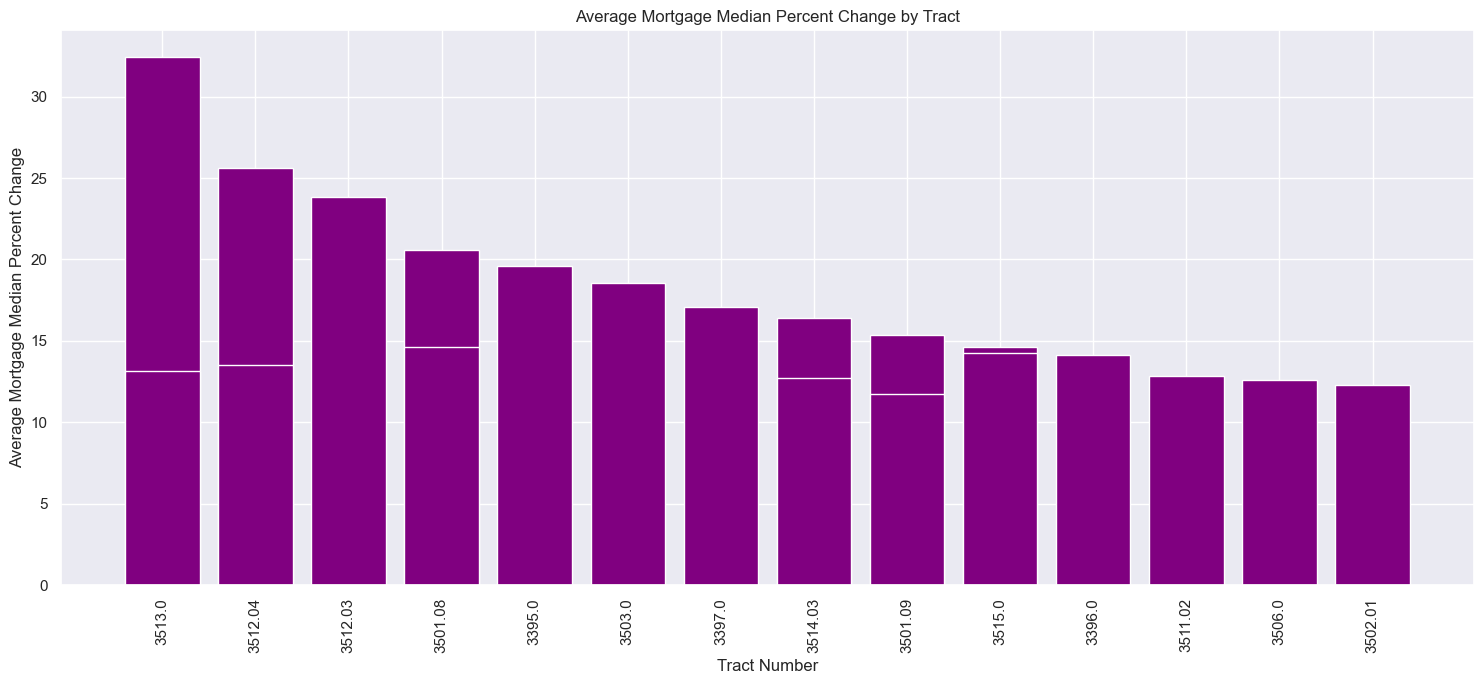

In [618]:
# Replace the commas and convert to numeric for all median columns
for median in ['Value Median', 'SMOC Median', 'Mortgage Median']:
    dp04[median] = dp04[median].str.replace(',', '')
    dp04[median] = pd.to_numeric(dp04[median], errors='coerce')

# Now, calculate the percent changes and plot for each median category
for median, color in zip(['Value Median', 'SMOC Median', 'Mortgage Median'], ['green', 'red', 'purple']):
    dp04[f'{median}_percent_change'] = dp04.groupby('Tract')[median].pct_change(fill_method=None)
    dp04[f'avg_{median}_percent_change'] = dp04.groupby('Tract')[f'{median}_percent_change'].transform('mean')
    dp04[f'{median}_percent_change'].fillna(dp04[f'avg_{median}_percent_change'], inplace=True)
    dp04.drop(f'avg_{median}_percent_change', axis=1, inplace=True)
    dp04[f'{median}_percent_change'] = dp04[f'{median}_percent_change'] * 100

    plot_data = dp04[['Tract', f'{median}_percent_change']]
    plot_data = plot_data.sort_values(by=f'{median}_percent_change', ascending=False)
    plot_data = plot_data.head(20)

    plt.figure(figsize=(15, 7))
    plt.bar(plot_data['Tract'].astype(str), plot_data[f'{median}_percent_change'], color=color)
    plt.xlabel('Tract Number')
    plt.ylabel(f'Average {median} Percent Change')
    plt.title(f'Average {median} Percent Change by Tract')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


### Classifying Rent Affordability

The code below uses an SVC model to classify the affordability of rent based on various housing features. The code creates weighted scores for categories related to the percentage of income spent on rent, then generates a summarized affordability score. It uses this score to categorize each tract into one of three affordability classes: high, medium, or low. The features used for predcing the rent affordability are a mix of housing unit characteristics, including the year built, occupancy status, and median values for rent and owner costs.

The code also generates a heatmap of the correlation matrix for numerical features. This visualization helps identify the relationships between different features and how they might influence rent affordability.

                      precision    recall  f1-score   support

  High Affordability       1.00      1.00      1.00         2
   Low Affordability       0.86      1.00      0.92        12
Medium Affordability       1.00      0.78      0.88         9

            accuracy                           0.91        23
           macro avg       0.95      0.93      0.93        23
        weighted avg       0.93      0.91      0.91        23



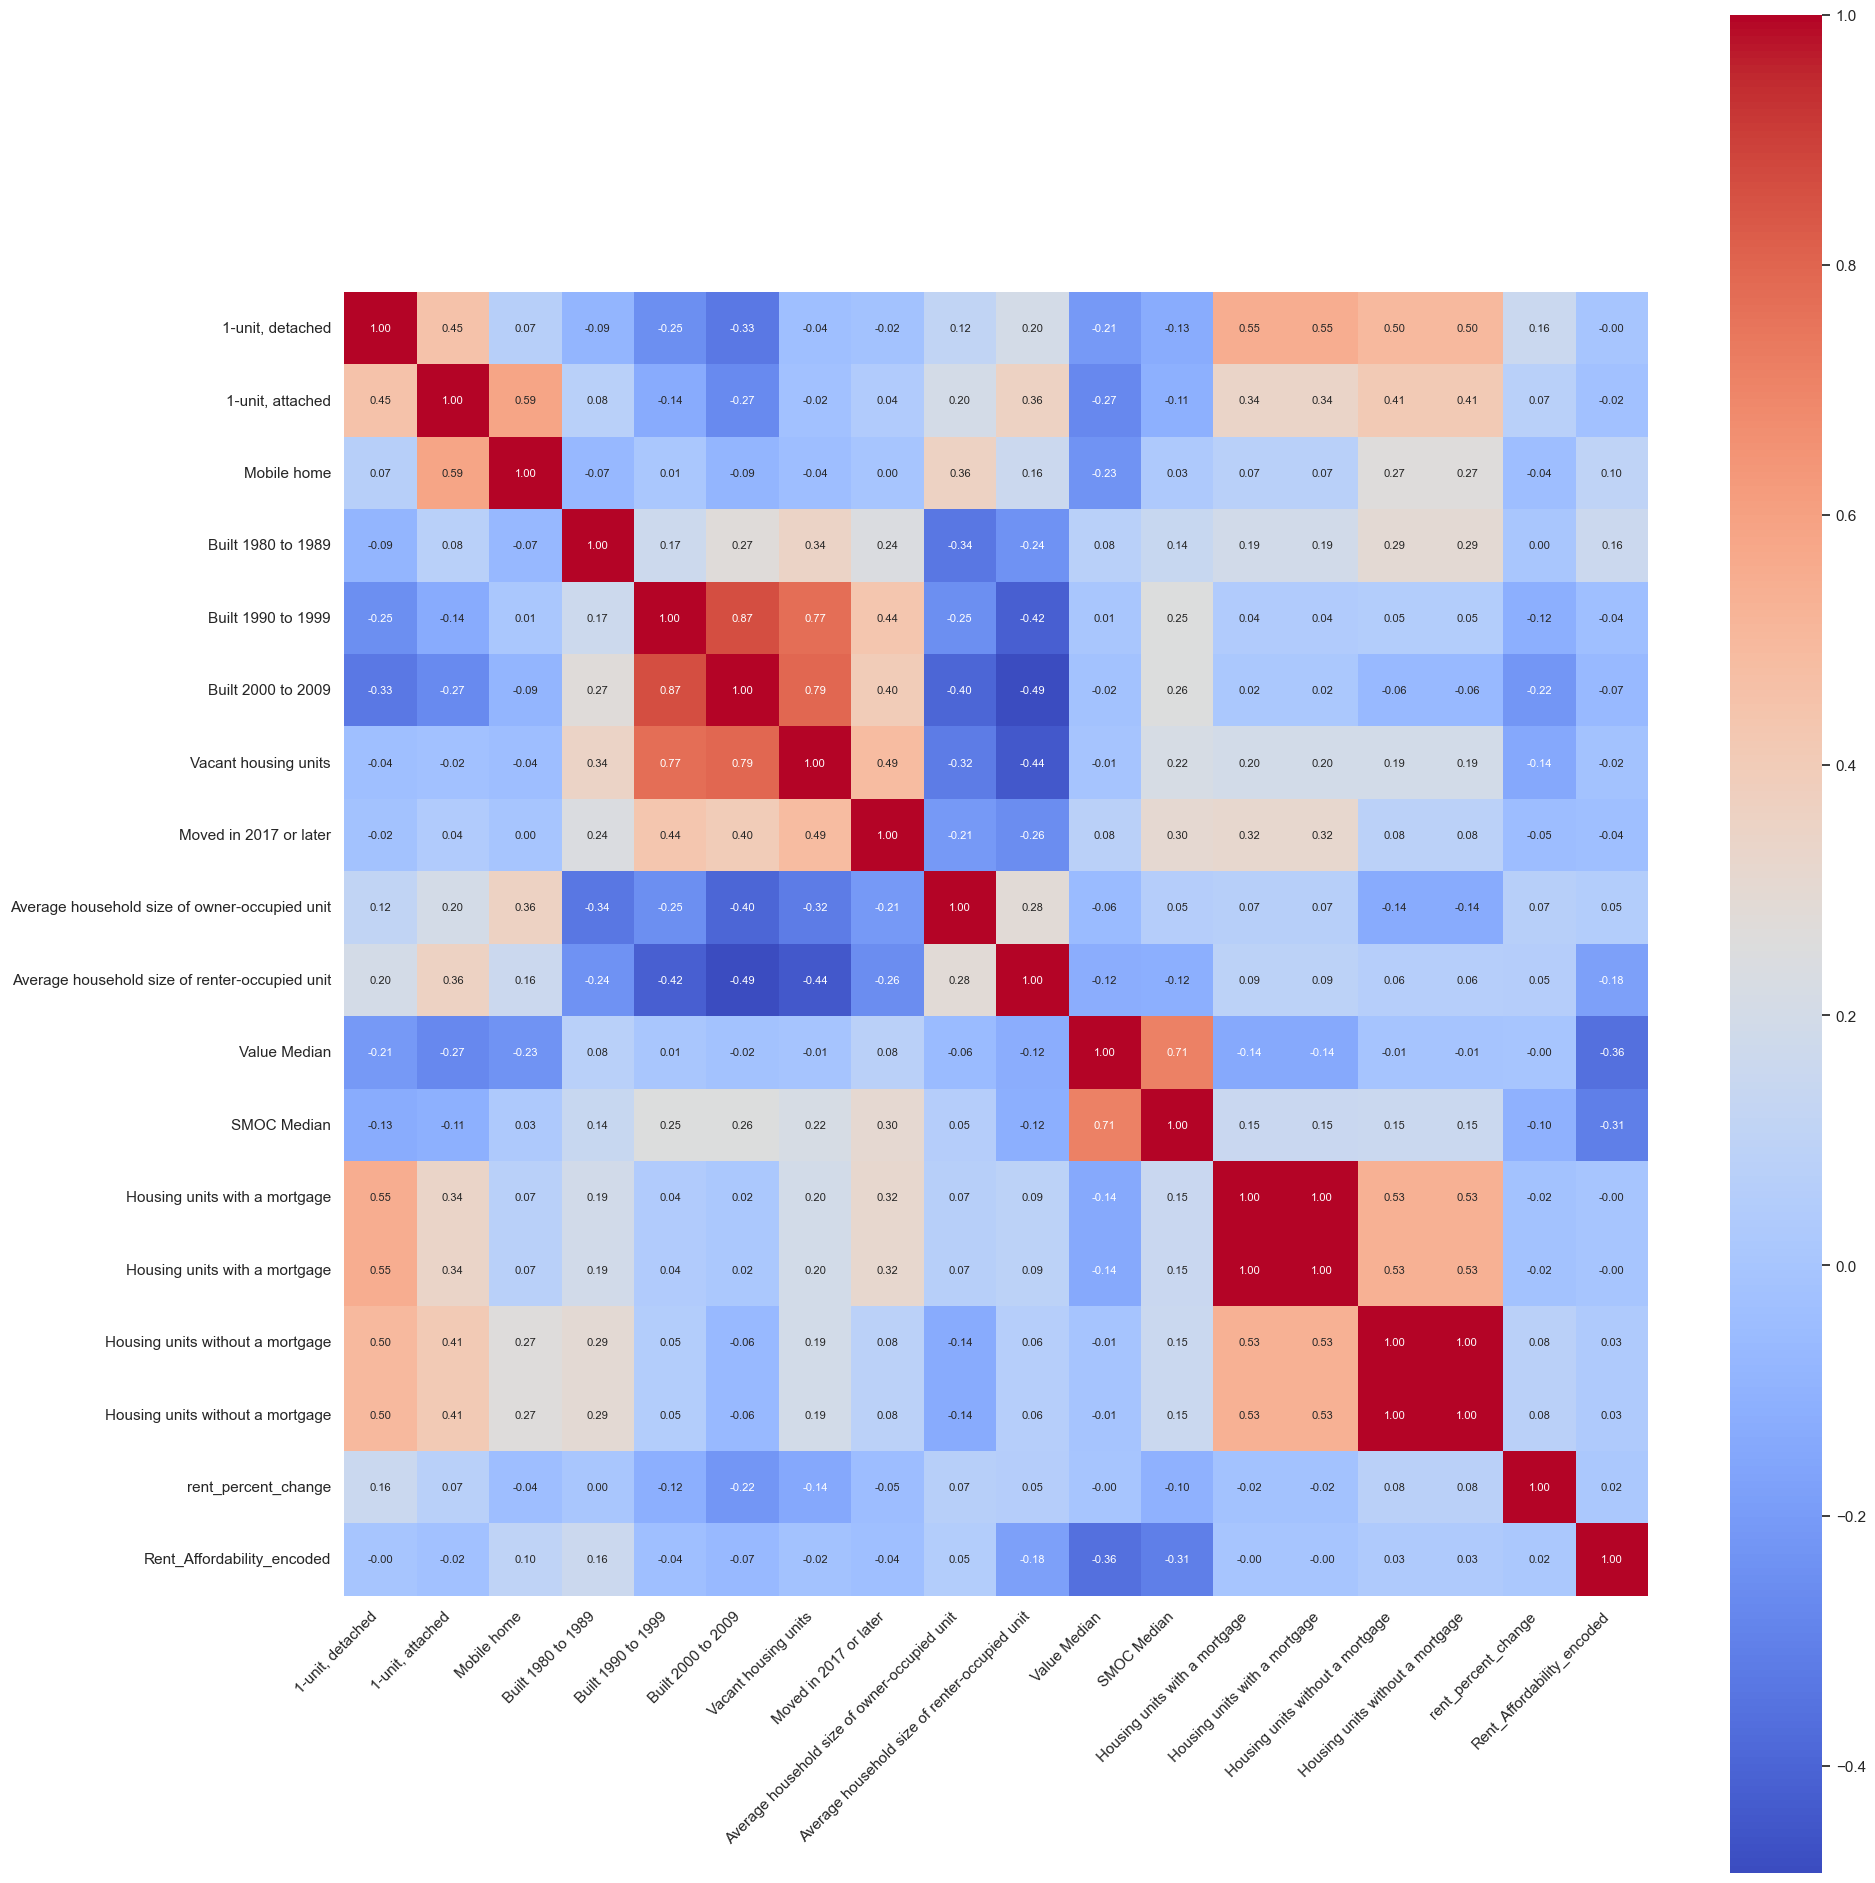

In [619]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns

dp04.columns = dp04.columns.str.strip()

weights = {
    'Less than 15.0 percent': 1,
    '15.0 to 19.9 percent.1': 2,
    '20.0 to 24.9 percent.2': 3,
    '25.0 to 29.9 percent.2': 4,
    '30.0 to 34.9 percent.2': 5,
    '35.0 percent or more.2': 6,
}

for category, weight in weights.items():
    dp04[category + '_weighted'] = dp04[category].astype(float) * weight

dp04['Affordability_Score'] = dp04[[cat + '_weighted' for cat in weights]].sum(axis=1)

conditions = [
    (dp04['Affordability_Score'] < 2000),
    (dp04['Affordability_Score'] >= 2000) & (dp04['Affordability_Score'] < 3500),
    (dp04['Affordability_Score'] >= 3500),
]
choices = ['High Affordability', 'Medium Affordability', 'Low Affordability']
dp04['Rent_Affordability'] = np.select(conditions, choices, default='Unknown')

le = LabelEncoder()
dp04['Rent_Affordability_encoded'] = le.fit_transform(dp04['Rent_Affordability'])

feature_columns = [
    '1-unit, detached',
    '1-unit, attached',
    '20 or more units',
    'Mobile home',
    'Built 1980 to 1989',
    'Built 1990 to 1999',
    'Built 2000 to 2009',
    'Occupied housing units',
    'Vacant housing units',
    'Owner-occupied',
    'Renter-occupied',
    'Moved in 2017 or later',
    'Average household size of owner-occupied unit',
    'Average household size of renter-occupied unit',
    'Value Median',
    'SMOC Median',
    'Housing units with a mortgage',
    'Housing units without a mortgage',
    'rent_percent_change'
]

X = dp04[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
y = dp04['Rent_Affordability_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc = SVC(kernel='linear')
svc.fit(X_train_scaled, y_train)

y_pred = svc.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=le.classes_))

numeric_features = dp04[feature_columns].select_dtypes(include=[np.number])
numeric_features['Rent_Affordability_encoded'] = dp04['Rent_Affordability_encoded']

corr_matrix = numeric_features.corr()

plt.figure(figsize=(20, 20)) 
corr_matrix = numeric_features.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, annot_kws={"size": 8})
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()

### Interesting Correlations

- 1-unit attached and 1-unit detached have a high correlation, suggesting areas with attached units around the GLX also have detached units.
- 'Value Median' has a significant positive correlation with 'Owner-occupied' and a negative correlation with 'Renter-occupied', which implies that high value property around the GLX is likely to be owner-occupied.
- 'Rent_percent_change' shows correlations with various features, which suggests that rent changes are influenced by a combination of factors including unit type, ownership, and when the units were moved into.
- '20 or more units' has an increasingly positive correlation with when the unit is built, suggesting that more modern buildings are designed to accommodate more people. This may not be correlated with the GLX, but rather a byproduct of Somerville and Medford increasingly urbanizing.

## Demographic Characteristics Analysis

In [620]:
s0601 = pd.read_csv('../../data/green-line-extension-data/s0601/s0601.csv')
s0802 = pd.read_csv('../../data/green-line-extension-data/s0802/s0802.csv')